In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The goal of this challenge is to build a model that ***predicts conversion rate*** and, based on the model, come up with ideas to ***improve revenue***.

My goal is practice 1)plotly 2)model selection pipeline.

- [Load and clean data](#loadandclean)
- [Visualizing feature distributions](#distributions)
 - [Bivariate plots](#bivariate)
 - [plotly](#plotly)
- [Predict conversion](#predict)
 - [GridSearchCV](#gridsearchcv)
 - [cross_val_score](#crossvalscore)
 - [Original features with random forest](#org)
 - [Drop useless feature and model again](#drop)
- [Recommendations](#recommendations)
- [Takeaways](#takeaways)

### Load and clean
<a id='loadandclean'></a>

In [2]:
path = '/Users/sjx/Desktop/conversion_data.csv'
df = pd.read_csv(path)
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [5]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [9]:
for col in df.columns:
    print('\n', col)
    print(df[col].value_counts())
    print(df[col].isnull().sum())


 country
US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64
0

 age
30     14346
28     14341
29     14158
27     14084
26     13931
31     13692
32     13507
25     13460
24     12960
33     12631
23     12336
34     12108
22     11701
35     11471
21     10966
36     10779
20     10156
37      9761
19      9349
38      8970
18      8466
39      8202
17      7597
40      7148
41      6401
42      5588
43      4904
44      4224
45      3634
46      2994
47      2504
48      2121
49      1629
50      1356
51      1093
52       935
53       627
54       520
55       394
56       286
57       247
58       165
59       127
60        94
61        71
62        59
63        35
64        27
65        15
66         9
67         5
68         5
69         3
70         2
77         1
79         1
111        1
73         1
72         1
123        1
Name: age, dtype: int64
0

 new_user
1    216744
0     99456
Name: new_user, dtype: int64
0

 source
S

Some illegal values in age (age > 100)

In [83]:
# df[df['age'] > 100].index
df.drop(df[df['age'] > 100].index, inplace=True)
df.shape

(316198, 6)

### Distributions
<a id='distributions'></a>

In [24]:
sns.set_palette('RdBu')

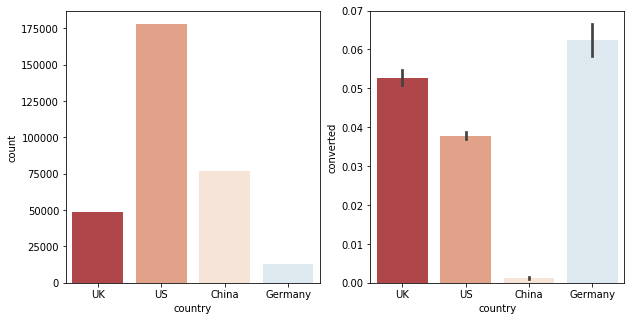

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax0 = sns.countplot(x='country', data=df, ax=axes[0])
ax1 = sns.barplot(x='country', y='converted', data=df, ax=axes[1])

Although Germany and UK have lower customer count, the conversion rate of these two countries are very high. Hypothesis: conversion rate might be related to geographical locations, eg. European countries have higher conversion. 

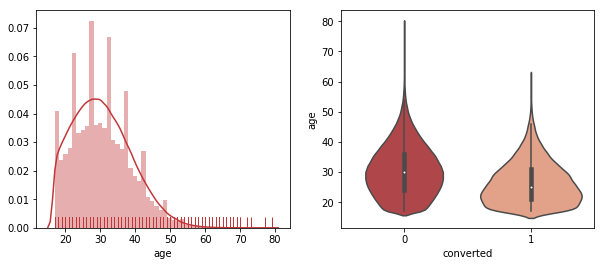

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
ax1 = sns.distplot(df['age'], rug=True, ax=ax1)
ax2 = sns.violinplot(x='converted', y='age', data=df, ax=ax2)

Generally speaking, younger people have a higher possibility of conversion, with several peaks between 10 and 50. Looking at the distribution for converted group and not converted group, the majority of conversion happens to 20-30 years old users. Hypothesis: the product is more attractive to young people.

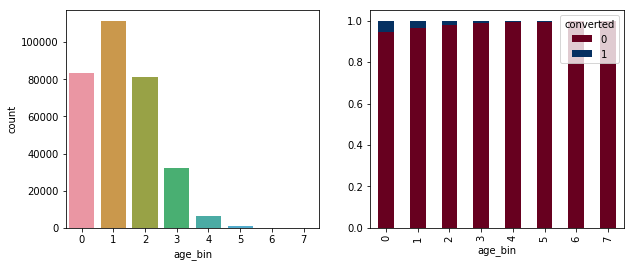

converted         0       1
age_bin                    
0           78904.0  4627.0
1          107901.0  3618.0
2           79531.0  1539.0
3           31999.0   371.0
4            6516.0    38.0
5            1079.0     5.0
6              66.0     NaN
7               4.0     NaN


In [31]:
df['age_bin'] = pd.cut(df['age'], 8).cat.codes
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
ax1 = sns.countplot(x='age_bin', data=df, ax=ax1)
tmp = df.groupby(['age_bin', 'converted']).size().unstack()
ax2 = tmp.div(tmp.sum(1).astype(float), axis=0).plot.bar(stacked=True, cmap='RdBu', ax=ax2)
ax2 = sns.barplot(x=)
plt.show()
print(tmp)

To have a closer look at each age group, how much percentage of users converted within each group. It turns out even in the group with highest conversion rate, there's only about 5% user converted. In most groups there's no converted user. So generally the product doesn't perform well.

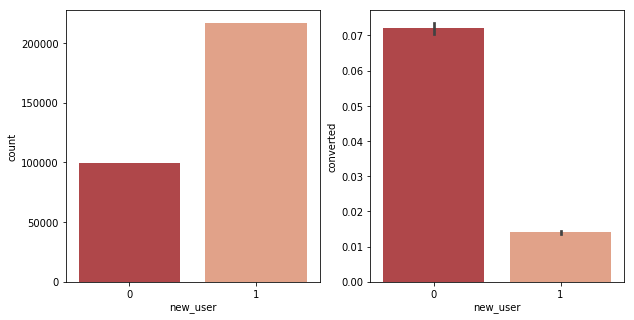

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax0 = sns.countplot(x='new_user', data=df, ax=axes[0])
ax1 = sns.barplot(x='new_user', y='converted', data=df, ax=axes[1])

Current user base has 1/3 old users and 2/3 new users. The conversion of old users is about 5x of new users. Clearly it is more popular with the old users. Maybe new users cannot find the value of the product because they haven't dig deep enough. We need to make the features more salient to new users.

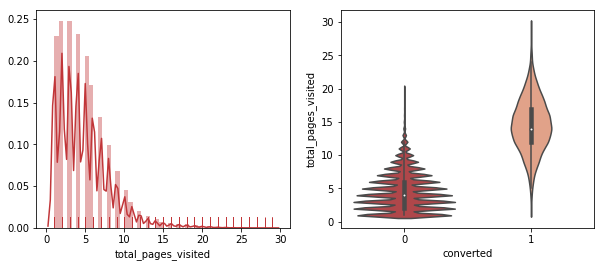

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
ax1 = sns.distplot(df['total_pages_visited'], rug=True, ax=ax1)
ax2 = sns.violinplot(x='converted', y='total_pages_visited', data=df, ax=ax2)

For converted users, average page view is 15. Most users who didn't convert only viewed less than 5 pages. This might be a confirmation of the last hypothesis.

#### Complemetary: bivariate (just trying out different types of plots)
<a id='bivariate'></a>

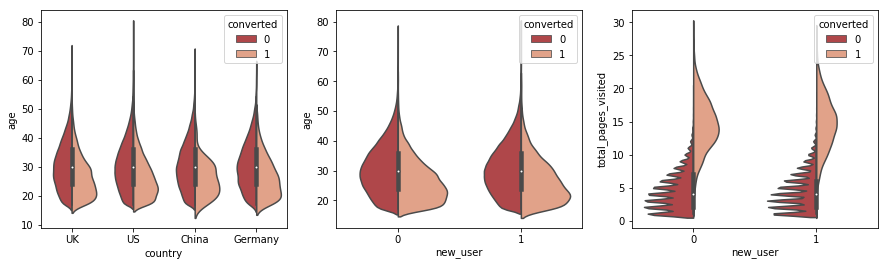

In [88]:
# 1 num, 2 cat
fig, axes = plt.subplots(1,3,figsize=(15,4))
ax0 = sns.violinplot(x='country', y='age', hue='converted', split=True, data=df, ax=axes[0])
ax1 = sns.violinplot(x='new_user', y='age', hue='converted', split=True, data=df, ax=axes[1])
ax2 = sns.violinplot(x='new_user', y='total_pages_visited', hue='converted', split=True, data=df, ax=axes[2])

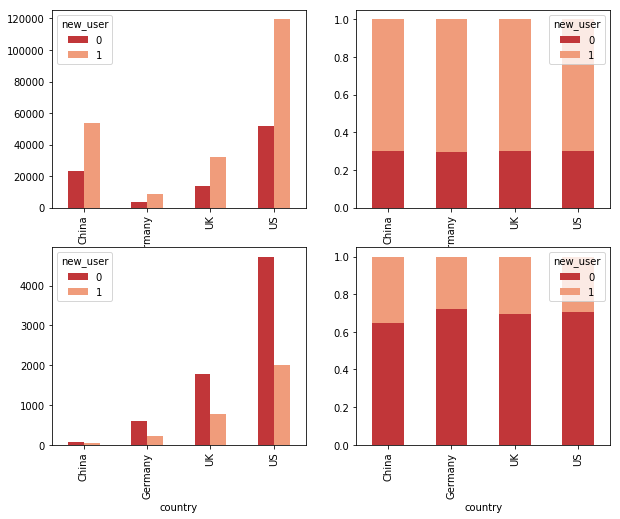

In [131]:
# 3 cat
tmp0 = df.loc[df['converted'] == 0].groupby(['country', 'new_user']).size().unstack()
tmp1 = df.loc[df['converted'] == 1].groupby(['country', 'new_user']).size().unstack()

fig, axes = plt.subplots(2,2,figsize=(10,8))
ax0 = tmp0.plot.bar(ax=axes[0,0])
ax1 = tmp0.div(tmp0.sum(1).astype(float), axis=0).plot.bar(stacked=True, ax=axes[0,1])
ax2 = tmp1.plot.bar(ax=axes[1,0])
ax3 = tmp1.div(tmp1.sum(1).astype(float), axis=0).plot.bar(stacked=True, ax=axes[1,1])

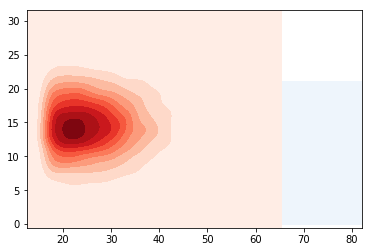

In [145]:
# 2 num, 1 cat 
tmp0 = df[df['converted'] == 0]
tmp1 = df[df['converted'] == 1]
ax = sns.kdeplot(tmp0['age'].values, tmp0['total_pages_visited'].values, shade=True, cmap='Blues')
ax = sns.kdeplot(tmp1['age'].values, tmp1['total_pages_visited'].values, shade=True, cmap='Reds') # v slow

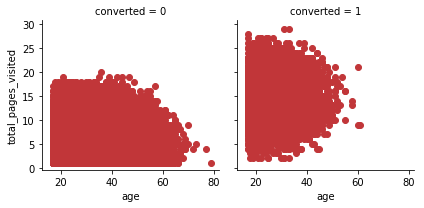

In [128]:
g = sns.FacetGrid(df, col='converted')
g.map(plt.scatter, 'age', 'total_pages_visited')

<span style='color:green'>Kde plot is very slow. If there are too many data points, don't scatter plot.

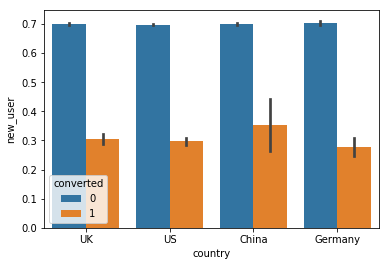

In [11]:
sns.barplot(x='country', y='new_user', hue='converted', data=df)

#### plotly
<a id='plotly'></a>

In [148]:
import plotly.graph_objs as go
import plotly.plotly as py

In [150]:
tmp = df.iloc[:100]
data = [
    go.Bar(x=tmp['country'], y=tmp['converted'])
]

url = py.plot(data)

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


### Predict (classification)
<a id='prediction'></a>

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#### Just for practice: GridSearchCV
<a id='gridsearchcv'></a>

In [44]:
# change into numerical for the sake of logistic regression
df = pd.get_dummies(df, columns=['country', 'source'])
df.head()

,age,new_user,total_pages_visited,converted,age_bin,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,1,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,0,1,0,0,1
2,28,1,4,0,1,0,0,0,1,0,0,1
3,39,1,5,0,2,1,0,0,0,0,0,1
4,30,1,6,0,1,0,0,0,1,0,0,1


In [45]:
x = df.drop(['converted','age_bin'], axis=1)
y = df['converted']
print(x.shape, y.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(316198, 10) (316198,)
(252958, 10) (63240, 10) (252958,) (63240,)


In [51]:
lr = LogisticRegression()
lr_params = {'penalty':['l1', 'l2'], 'C':[1,10,100,1000]}

rf = RandomForestClassifier()
xg = GradientBoostingClassifier()
tree_params = {'bootstrap': [True, False],
             'max_depth': [10, 50, 100],
#              'max_features': ['auto', 'sqrt'],
#              'min_samples_leaf': [1, 2, 4],
#              'min_samples_split': [2, 5, 10],
             'n_estimators': [10, 50, 100]}    

In [52]:
def tune(clf, params):
    print()
    print(clf)
    gscv = GridSearchCV(clf, params, cv=KFold(5))
    gscv.fit(x_train, y_train)
    print('Best params:')
    print(gscv.best_params_)
#     print('\nAverage scores for each parameter combination:')
#     means = clf.cv_results_['mean_test_score']
#     for mean, param in zip(means, clf.cv_results_['params']):
#         print(mean, param)
    print('\nPredictions:')
    preds = gscv.predict(x_test)
    print(classification_report(y_test, preds))
    print('\nAccuracy score:', accuracy_score(y_test, preds))
    

Above code from [sklearn doc](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py). <span style='color:red'>Need to check out more code examples on Kaggle.

In [53]:
tune(lr, lr_params)
tune(rf, tree_params)
tune(xg, tree_params)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best params:
{'C': 10, 'penalty': 'l1'}

Predictions:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99     61205
          1       0.86      0.69      0.77      2035

avg / total       0.99      0.99      0.99     63240


Accuracy score: 0.9865591397849462

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Best pa

NameError: name 'tuen' is not defined

Still, random forest is way slower than logistic regression. <span style='color:red'>Do we need to change string variables into numeric for rf tho?

#### Just for practice: cross_val_score
<a id='crossvalscore'></a>

In [71]:
lr = LogisticRegression(C=10, penalty='l1')
print(lr)
print('cross_val_score:', cross_val_score(lr, x_train, y_train, cv=5))
preds = lr.fit(x_train, y_train).predict(x_test)
print('accuracy_score:', accuracy_score(y_test, preds))
fi = pd.Series(lr.coef_[0], index=x_train.columns).sort_values()
print('Feature importance:', fi)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
cross_val_score: [0.98661844 0.98543248 0.98592663 0.98606472 0.98622285]
accuracy_score: 0.9865591397849462
Feature importance:
 country_China         -5.974065
source_Direct         -3.020326
source_Seo            -2.861605
source_Ads            -2.860445
country_US            -2.775446
country_UK            -2.394482
country_Germany       -2.199707
new_user              -1.742583
age                   -0.074557
total_pages_visited    0.758600
dtype: float64


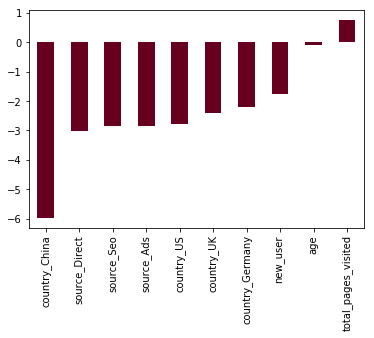

In [72]:
fi.plot.bar(cmap='RdBu')

In [75]:
rf = RandomForestClassifier()
print(rf)
print('cross_val_score:', cross_val_score(rf, x_train, y_train, cv=5))
preds = rf.fit(x_train, y_train).predict(x_test)
print('accuracy_score:', accuracy_score(y_test, preds))
fi = pd.Series(rf.feature_importances_, index=x_train.columns).sort_values()
print('Feature importance:', fi)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
cross_val_score: [0.98412793 0.98315939 0.98351518 0.98402878 0.98479967]
accuracy_score: 0.985246679316888
Feature importance: country_Germany        0.001846
source_Direct          0.002290
country_UK             0.002558
source_Ads             0.002669
source_Seo             0.002813
country_US             0.002996
country_China          0.028109
new_user               0.038028
age                    0.108187
total_pages_visited    0.810505
dtype: float64


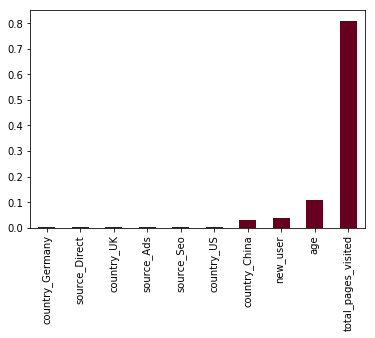

In [76]:
fi.plot.bar(cmap='RdBu')

<span style='color:red'>The feature importances of logistic regression and random forest classifier are very different (inversed actually).</span> Honestly I don't know how to recommend in this case. But in real takehome challenges I guess I'll just use tree-based models, because of its robustness (no need to turn textual values to numerical, potential mistakes avoided) and ease of interpretation.

<span style='color:red'>A question: should I encode categorical variables into one-hot then? It seems that one-hot might diffuse feature importance...</span>

#### Use the original df and rf
<a id='org'></a>

In [79]:
df = pd.read_csv(path)
df.drop(df[df['age'] > 100].index, inplace=True)
df['country'] = df['country'].astype('category').cat.codes
df['source'] = df['source'].astype('category').cat.codes
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,2,25,1,0,1,0
1,3,23,1,2,5,0
2,3,28,1,2,4,0
3,0,39,1,2,5,0
4,3,30,1,2,6,0


cross_val_score: [0.98387131 0.98393422 0.98319593 0.98418689 0.9840393 ]
accuracy_score: 0.9848197343453511
Feature importances: source                 0.016618
new_user               0.044774
country                0.047310
age                    0.106522
total_pages_visited    0.784777
dtype: float64


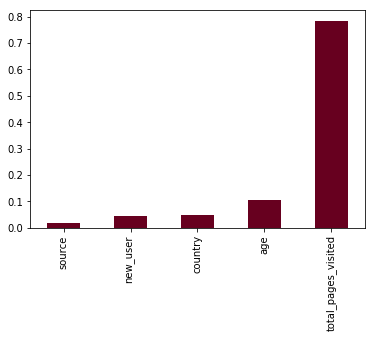

In [80]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('converted', axis=1), df['converted'])

rf = RandomForestClassifier()
print('cross_val_score:', cross_val_score(rf, x_train, y_train, cv=5))
preds = rf.fit(x_train, y_train).predict(x_test)
print('accuracy_score:', accuracy_score(y_test, preds))
fi = pd.Series(rf.feature_importances_, index=x_train.columns).sort_values()
print('Feature importances:', fi)
fi.plot.bar(cmap='RdBu')

Umm, not that much difference with one-hot encoding... I guess if there are not too many variables <span style='color:green'>I will use one-hot-encoding then.</span>

But it's still hard to do the recommendation because total_page_visited is not something that we can deliberately change from designing side. User likes the product first, then he will view many more pages. It's also possible that as he views more pages, he becomes more in favor of the product. Therefore, it still confirms former hypothesis that our highlight is buried too deep. 

(can also try do attract older users? as we don't actually know what product it is so not able to offer detailed actionable recommendations... maybe change the layout to be more conservative? but then there's chance to lose young users. idk, i'll refer to the answer.)

#### Drop total_pages_visited, balance class weight according to number of samples in each class
<a id='drop'></a>

cross_val_score: [0.7381615  0.74273666 0.74020662 0.75770609 0.73498777]
accuracy_score: 0.7399367488931057
Feature importances: source      0.015753
age         0.232112
new_user    0.372774
country     0.379362
dtype: float64


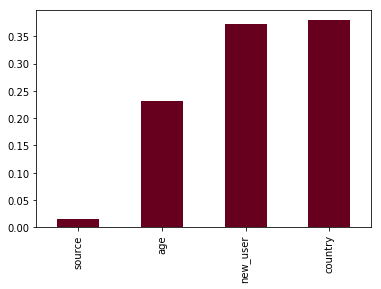

In [81]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['converted', 'total_pages_visited'], axis=1), df['converted'])

rf = RandomForestClassifier(class_weight='balanced')
print('cross_val_score:', cross_val_score(rf, x_train, y_train, cv=5))
preds = rf.fit(x_train, y_train).predict(x_test)
print('accuracy_score:', accuracy_score(y_test, preds))
fi = pd.Series(rf.feature_importances_, index=x_train.columns).sort_values()
print('Feature importances:', fi)
fi.plot.bar(cmap='RdBu')

### Recommendations
<a id='recommendations'></a>

After weighing, the most important features turn out to be country and new_user. These two are nearly equally important. Age matters too while source is basically irrelevant.
<br> 
- Focus more on European market. While the conversion rate there is much higher, total number of users is much lower than that of the US. The marketing team can come up with some geographic related promotion events, such as discount limited in Germany/UK to attract more European users.
- The performance in Chinese market is very bad. It could be that the product information is not translated into Chinese at all or auto-translation does a bad job. For this issue, the product team can check out the product to see how to improve communication with Chinese users. Or the product doesn't fit Chinese culture. Or it is blocked due to censorship.
- The product performs well for old users/accounts. Maybe it needs some time to dig up the highlight features, or it might require some practice to get a hold of the product (eg. Photoshop). The marketing team could offer some benefits to new users to attract them, such as discount in first month subscription, user guide or tutorials, etc.
- The product is particularly popular with young audience. Almost nobody over 30 converted. If we still want to target at a middle age market, we have to improve the product to be more friendly in layout, content etc., eg. maybe less aggressive in color use, less slangs and more formal expressions, etc.

Feedback from others' failed takehome challenges:
- Discussion of why or whether it "makes sense" that those are the influential factors
- Valid use of statistics for rigorous definition of "influential"

In [156]:
import scipy.stats as stats

stats.chisquare(f_obs = df.loc[df['converted'] == 0, 'country'].value_counts().sort_index(), 
               f_exp = df.loc[df['converted'] == 1, 'country'].value_counts().sort_index())

Power_divergenceResult(statistic=62145438.3122732, pvalue=0.0)

### Takeaways
<a id='takeaways'></a>

- sns.set_palette()
- This one is still a classification problem -> target: categorical variable, so:
 - univariate: categorical variable then countplot, map to target by barplot; numerical then histplot, map to target by violin/boxplot
 - bivariate: 2 cats, hard to visualize <span style='color:green'>(could use bar with hue if target is 0-1)</span>; 1 cat 1 num, violin hue split by target; 2 num, scatter or kde depending on data volum
- GridSearchCV: the clf trained is GridSearchCV, not the parame estimator, so cannot plot feature_importances_
- Rationalize the most important deatures
- Drop some misleading columns then fit the model again to check updated important features
- Combine feature importance and previous distribution plots, "comfirm the distributions" <span style='color:red'>Python has partial dependence plot too, check out tomorrow</span>
- Statistical analysis to verify if there's a real difference, when the difference in the plot is not obvious?
- As many insights as possible!! Cover good AND bad segments. Actionable next steps.
- <span style='color:red'>Need to talk about if the model "makes sense" by analysing the accuracy (this is a imbalance class example)</span>

Now deal with the problems I marked as <span style='color:red'>red</span> along the way.
<br><br>**? More examples on GridSearchCV ?**
<br>Lessons learned from [this kernel](https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish) (the comments are pretty to the point!):
- Train test imputed in the same way (write a cleaning function!)
- Also there is a better way to use dummies: col_dummies = pd.get_dummies(df.col), df[val1] = col_dummies.val1, etc. (from [this kernel](https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv))
- GridSearchCV: 
 - make_scorer(accuracy_score)
 - clf = grid_obj.best_estimator_ (otherwise the final param combination! no use to just print out best_params_)
- If want to choose one from different models, first cross_val, choose the one with highest score, then train that model with all training samples

**? String values for random forest ?**
<br>For Python/sklearn, yes, we need to encode them into numerical values. (But for R or WEKA apparently they can handle the situation with raw input, that's lucky.)

**? Imputing missing values for test set ?**
<br>From various posts it seems ok to impute with mean of training set. Data leakage only happens if you also use test set to calculate the mean.
<br>Not about the discrepency between train and test set, but another method of imputation: add an [indicator column](https://www.kaggle.com/dansbecker/handling-missing-values) to "guess" less randomly.

**? Interpretation of coef_ of logistic regression ?**
<br>Actually it's not feature importance. It's the weights for each x (feature) in the model, and the values would be bias if the features are not properly scaled. In this case, total_pages_visited has a fat higher value than one-hot encoded variables, so its coef is the largest. 
<br>Recommed not to use logistic regression. But if required, there is a method to [standardize the coefs (or standard the data itself)](https://stackoverflow.com/a/34052747/9265279).

**? Partial dependence plot in python ?**
<br>There is [sklearn documentation](https://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html) and a lib called [PDPBox](https://towardsdatascience.com/introducing-pdpbox-2aa820afd312). Might need some time to digest, I'll go with basic plotting for now.